<a href="https://colab.research.google.com/github/getreadytoUG/KDT_WORK/blob/main/%EA%B3%BC%EC%A0%9C_%ED%95%9C%EA%B8%80_%EC%9B%8C%EB%93%9C_%EC%9E%84%EB%B2%A0%EB%94%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 과제
* [AI Hub](https://www.aihub.or.kr/) 에 공개되어 있는 한국어 데이터셋을 활용하여 한국어 워드 임베딩 구축
* 사용 데이터 : [[한국어] 감성 대화 말뭉치](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=86)

### 1. 필요한 모듈 Import

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model
import gensim

### 2. 데이터 셋 들고오기

In [2]:
train_df = pd.read_excel("/content/drive/MyDrive/KDT/9. 자연어 처리/data/감성 대화 말뭉치/train/train.xlsx")
train_df.head()

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
0,1,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.,NaN,NaN
1,2,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.,NaN,NaN
2,3,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,스트레스받지 않기 위해선 인간관계에 있어 약간의 거리를 두는 게 좋겠군요.,NaN,NaN
3,4,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,직장 사람들과 이야기를 해 보겠다고 결심하셨군요.,NaN,NaN
4,5,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,항상 먼저 인사하게 되어 화가 나셨군요. 어떻게 하면 신입사원에게 화났음을 표현할 ...,NaN,NaN


In [3]:
train_df = train_df[["사람문장1", "시스템문장1", "사람문장2", "시스템문장2"]]
train_df

,사람문장1,시스템문장1,사람문장2,시스템문장2
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,스트레스받지 않기 위해선 인간관계에 있어 약간의 거리를 두는 게 좋겠군요.
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,직장 사람들과 이야기를 해 보겠다고 결심하셨군요.
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,항상 먼저 인사하게 되어 화가 나셨군요. 어떻게 하면 신입사원에게 화났음을 표현할 ...
...,...,...,...,...
51625,나이가 먹고 이제 돈도 못 벌어 오니까 어떻게 살아가야 할지 막막해. 능력도 없고.,경제적인 문제 때문에 막막하시군요. 마음이 편치 않으시겠어요.,아무것도 할 수 없는 내가 무가치하게 느껴지고 실망스러워.,지금 할 수 있는 가장 합리적인 행동은 무엇인가요?
51626,몸이 많이 약해졌나 봐. 이제 전과 같이 일하지 못할 것 같아 너무 짜증 나.,건강에 대한 어려움 때문에 기분이 좋지 않으시군요. 속상하시겠어요.,마음 같아서는 다 할 수 있는 일인데 이젠 몸이 안 따라와 주니 화만 나.,어떻게 하면 지금의 기분을 나아지게 할 수 있을까요?
51627,이제 어떻게 해야 할지 모르겠어. 남편도 그렇고 노후 준비도 안 되어서 미래가 걱정돼.,노후 준비에 대한 어려움 때문에 걱정이 많으시겠어요.,주변 사람들은 다 노후 준비도 잘해두었던데 난 어떻게 해야 할지 모르겠어. 막막하기...,지금의 상황에서 할 수 있는 가장 좋은 행동이 무엇일까요?
51628,몇십 년을 함께 살았던 남편과 이혼했어. 그동안의 세월에 배신감을 느끼고 너무 화가 나.,가족과의 문제 때문에 속상하시겠어요.,이제 할 수 있는 일도 없고 이렇게 힘들게 사는 게 불만스럽기만 해.,지금의 감정을 나아지게 할 수 있는 어떤 방법이 있을까요?


In [4]:
df = pd.DataFrame({"document": pd.concat([train_df["사람문장1"], train_df["시스템문장1"], train_df["사람문장2"], train_df["시스템문장2"]])})
df.head()

,document
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.


### 3. 데이터셋의 결측값을 제거

In [5]:
df = df.dropna().reset_index(drop=True)
print(f"필터링된 데이터셋 총 개수: {len(df)}")

필터링된 데이터셋 총 개수: 206520


### 4. 열을 기준으로 중복된 데이터 제거

In [6]:
processed_df = df.drop_duplicates(["document"]).reset_index(drop=True)
processed_df

,document
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.
...,...
200495,어떻게 하는 것이 지금의 상황에 변화를 줄 수 있을까요?
200496,지금 할 수 있는 가장 합리적인 행동은 무엇인가요?
200497,지금의 상황에서 할 수 있는 가장 좋은 행동이 무엇일까요?
200498,지금의 감정을 나아지게 할 수 있는 어떤 방법이 있을까요?


### 5. 특수 문제 제거

In [7]:
processed_df["document"] = processed_df["document"].str.replace("[^가-힣 ]", "")
processed_df

<ipython-input-7-92fc17732caa>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  processed_df["document"] = processed_df["document"].str.replace("[^가-힣 ]", "")


,document
0,일은 왜 해도 해도 끝이 없을까 화가 난다
1,이번 달에 또 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나
2,회사에 신입이 들어왔는데 말투가 거슬려 그런 애를 매일 봐야 한다고 생각하니까 스트...
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜 일도 많은 데 정말 분하고 섭섭해
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나
...,...
200495,어떻게 하는 것이 지금의 상황에 변화를 줄 수 있을까요
200496,지금 할 수 있는 가장 합리적인 행동은 무엇인가요
200497,지금의 상황에서 할 수 있는 가장 좋은 행동이 무엇일까요
200498,지금의 감정을 나아지게 할 수 있는 어떤 방법이 있을까요


### 6. 길이가 너무 짧은 단어 제거 (단어의 길이가 1 이하)

In [8]:
processed_df["document"] = processed_df["document"].apply(
    lambda x: " ".join([token for token in x.split() if len(token) > 1])
    )

processed_df

,document
0,일은 해도 해도 끝이 없을까 화가 난다
1,이번 달에 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가
2,회사에 신입이 들어왔는데 말투가 거슬려 그런 애를 매일 봐야 한다고 생각하니까 스트...
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜 일도 많은 정말 분하고 섭섭해
4,얼마 입사한 신입사원이 나를 무시하는 같아서 너무 화가
...,...
200495,어떻게 하는 것이 지금의 상황에 변화를 있을까요
200496,지금 있는 가장 합리적인 행동은 무엇인가요
200497,지금의 상황에서 있는 가장 좋은 행동이 무엇일까요
200498,지금의 감정을 나아지게 있는 어떤 방법이 있을까요


### 7. 전체 단어의 갯수가 5개 이하인 데이터를 필터

In [9]:
processed_df = processed_df[processed_df.document.apply(
    lambda x: len(str(x).split()) > 5)].reset_index(drop = True)

processed_df

,document
0,일은 해도 해도 끝이 없을까 화가 난다
1,이번 달에 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가
2,회사에 신입이 들어왔는데 말투가 거슬려 그런 애를 매일 봐야 한다고 생각하니까 스트...
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜 일도 많은 정말 분하고 섭섭해
4,얼마 입사한 신입사원이 나를 무시하는 같아서 너무 화가
...,...
145963,어떻게 하는 것이 지금의 상황에 변화를 있을까요
145964,지금 있는 가장 합리적인 행동은 무엇인가요
145965,지금의 상황에서 있는 가장 좋은 행동이 무엇일까요
145966,지금의 감정을 나아지게 있는 어떤 방법이 있을까요


### 8. 불용어 제거

In [10]:
stop_word = "아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓"
stop_words = [w for w in stop_word.split()]
print(len(stop_words))
print(stop_words[:10])

888
['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [11]:
tokenized_doc = processed_df["document"].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [s_word for s_word in x if s_word not in stop_words])

tokenized_doc

0                                     [일은, 끝이, 없을까, 화가, 난다]
1          [달에, 급여가, 깎였어, 물가는, 오르는데, 월급만, 자꾸, 깎이니까, 너무, 화가]
2         [회사에, 신입이, 들어왔는데, 말투가, 거슬려, 애를, 매일, 봐야, 한다고, 생...
3         [직장에서, 막내라는, 이유로, 나에게만, 온갖, 심부름을, 시켜, 일도, 정말, ...
4                       [입사한, 신입사원이, 나를, 무시하는, 같아서, 너무, 화가]
                                ...                        
145963                            [것이, 지금의, 상황에, 변화를, 있을까요]
145964                           [있는, 가장, 합리적인, 행동은, 무엇인가요]
145965                  [지금의, 상황에서, 있는, 가장, 좋은, 행동이, 무엇일까요]
145966                      [지금의, 감정을, 나아지게, 있는, 방법이, 있을까요]
145967                          [지금의, 상황에, 변화를, 만들어낼, 있을까요]
Name: document, Length: 145968, dtype: object

In [12]:
tokenized_doc = tokenized_doc.to_list()

In [13]:
print(len(tokenized_doc))
print(tokenized_doc[:3])

145968
[['일은', '끝이', '없을까', '화가', '난다'], ['달에', '급여가', '깎였어', '물가는', '오르는데', '월급만', '자꾸', '깎이니까', '너무', '화가'], ['회사에', '신입이', '들어왔는데', '말투가', '거슬려', '애를', '매일', '봐야', '한다고', '생각하니까', '스트레스', '받아']]


### 9. Tokenizer 사용

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [15]:
vocab_size = len(word2idx)
print(f"단어 사전의 크기: {vocab_size}")

단어 사전의 크기: 106427


In [16]:
print(encoded[0])

[252, 3426, 1616, 21, 2017]


In [17]:
len(encoded)

145968

### 10. Skipgrams 사용

In [18]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=3) for sample in encoded[:100]]
print(f"전체 샘플 수 : {len(skip_grams)}")

전체 샘플 수 : 100


In [19]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
print(f"3 pairs: {pairs[:3]}")
print(f"3 labels: {labels[:3]}")

3 pairs: [[1616, 3121], [21, 3426], [3426, 72754]]
3 labels: [0, 1, 0]


In [20]:
print(len(pairs))
print(len(labels))

36
36


In [21]:
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
        idx2word[pairs[i][0]], pairs[i][0],
        idx2word[pairs[i][1]], pairs[i][1],
        labels[i]
    ))

(없을까 (1616), 아빠에게 (3121)) -> 0
(화가 (21), 끝이 (3426)) -> 1
(끝이 (3426), 삼억을 (72754)) -> 0
(난다 (2017), 고민하게 (30048)) -> 0
(화가 (21), 일은 (252)) -> 1


### 11. train 데이터 사용

In [22]:
training_dataset = [skipgrams(sample, vocabulary_size=vocab_size, window_size=3) for sample in encoded[:100]]
len(training_dataset)

100

In [23]:
# 중심 단어를 위한 임베딩 테이블
embedding_dim = 100

w_inputs = Input(shape=(1,), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

c_inputs = Input(shape=(1,), dtype='int32')
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

In [24]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])

dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)

output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               1064270   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 100)               1064270   ['input_2[0][0]']         

In [25]:
model.compile(loss="binary_crossentropy", optimizer="adam")

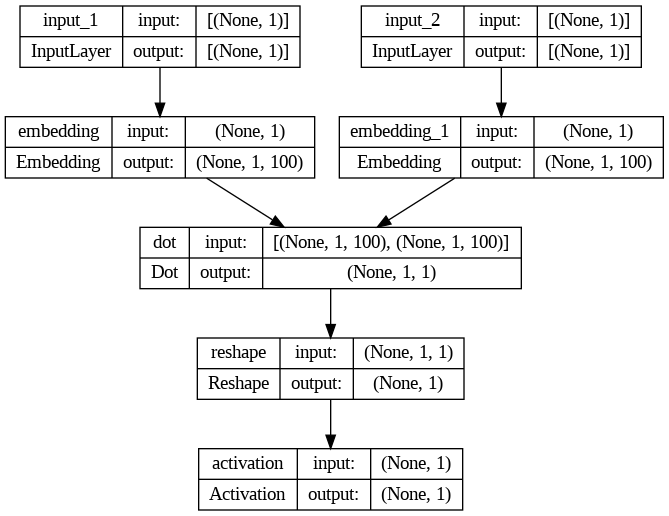

In [26]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [27]:
for epoch in range(100):
    loss = 0
    for _, elem in enumerate(training_dataset):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype="int32")
        second_elem = np.array(list(zip(*elem[0]))[1], dtype="int32")
        labels = np.array(elem[1], dtype="int32")

        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X, Y)
    print("Epoch: ", epoch+1, "Loss: ", loss)

Epoch:  1 Loss:  69.31181311607361
Epoch:  2 Loss:  68.3467720746994
Epoch:  3 Loss:  66.65727818012238
Epoch:  4 Loss:  63.604752600193024
Epoch:  5 Loss:  58.933432042598724
Epoch:  6 Loss:  52.94274836778641
Epoch:  7 Loss:  46.25241556763649
Epoch:  8 Loss:  39.48019230365753
Epoch:  9 Loss:  33.09304542839527
Epoch:  10 Loss:  27.381043553352356
Epoch:  11 Loss:  22.475065991282463
Epoch:  12 Loss:  18.385235384106636
Epoch:  13 Loss:  15.045677818357944
Epoch:  14 Loss:  12.353776205331087
Epoch:  15 Loss:  10.198088183999062
Epoch:  16 Loss:  8.474567715078592
Epoch:  17 Loss:  7.093799436464906
Epoch:  18 Loss:  5.982636671513319
Epoch:  19 Loss:  5.082981610670686
Epoch:  20 Loss:  4.349461121484637
Epoch:  21 Loss:  3.7469371054321527
Epoch:  22 Loss:  3.248273669742048
Epoch:  23 Loss:  2.832493871450424
Epoch:  24 Loss:  2.483325353823602
Epoch:  25 Loss:  2.188080823980272
Epoch:  26 Loss:  1.9368080385029316
Epoch:  27 Loss:  1.7216484672389925
Epoch:  28 Loss:  1.5363537

### 12. 유사도 측정

In [28]:
f = open("vectors.txt", "w")
f.write("{} {}\n".format(vocab_size, embedding_dim))
vectors = model.get_weights()[0]
print(vectors)
print(len(vectors))

for word, i in tokenizer.word_index.items():
    f.write("{} {}\n".format(word, " ".join(map(str, list(vectors[i-1, :])))))
f.close()

[[ 0.04921449  0.00645556 -0.01926174 ...  0.00278509  0.01303611
  -0.02683721]
 [-0.7622536   0.66437316  0.20797934 ... -0.7940242   0.22192915
   0.6957041 ]
 [-0.5016825  -0.32652518 -0.59868294 ... -0.6744238  -0.56929976
  -0.19871078]
 ...
 [ 0.00965869 -0.00571679  0.03033148 ...  0.01471441  0.02578339
   0.01419334]
 [ 0.03421992 -0.03189103 -0.02732773 ...  0.04262337 -0.00240182
   0.04474974]
 [-0.0056744  -0.04002129 -0.04470388 ...  0.00116137  0.03180135
   0.04225842]]
106427


In [29]:
w2v = gensim.models.KeyedVectors.load_word2vec_format("./vectors.txt", binary=False)

In [ ]:
w2v.most_similar(positive=["급여"])

In [31]:
w2v.most_similar(positive=["회사"])

[('이럴수가', 0.39787107706069946),
 ('병원도', 0.38503387570381165),
 ('과제하는', 0.37797850370407104),
 ('관리비', 0.376086562871933),
 ('거금을', 0.37117379903793335),
 ('회복될거예요', 0.36978086829185486),
 ('기계로만', 0.3652711808681488),
 ('헌신하셨군요', 0.3648619055747986),
 ('대세였는데', 0.3603913187980652),
 ('후배도', 0.36028772592544556)]

In [32]:
w2v.most_similar(positive=["행동"])

[('수학여행에서', 0.46191880106925964),
 ('좋아지시군요', 0.41838204860687256),
 ('조문객이', 0.4002646207809448),
 ('실수였다고', 0.37992674112319946),
 ('생각을', 0.3793325424194336),
 ('해봤는데', 0.3687926232814789),
 ('무엇인가가', 0.3681495487689972),
 ('초의', 0.3676331341266632),
 ('문건', 0.3655570447444916),
 ('과정이라', 0.3628462851047516)]

In [33]:
w2v.most_similar(positive=["형편"])

[('말도없고', 0.4971463084220886),
 ('빠진다고', 0.3940088152885437),
 ('줄이셔서', 0.3817748725414276),
 ('게으른', 0.38088372349739075),
 ('감염이', 0.37866416573524475),
 ('불안한데', 0.3746660053730011),
 ('위주에서', 0.3702377676963806),
 ('어색함에', 0.3695724606513977),
 ('제시해줘서', 0.36685431003570557),
 ('의기소침한', 0.3650786876678467)]